In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.9 MB/s eta 0:00:00


# 1. Load libraries and Data


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [3]:
# Dataset of MNIST numbers
# It is a labeled dataset with images of 28x28 pixels
data_fetcher = keras.datasets.mnist

# 2. Fetch and split the data

In [4]:
(train_images,train_labels),(test_images,test_labels)=data_fetcher.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Sample image

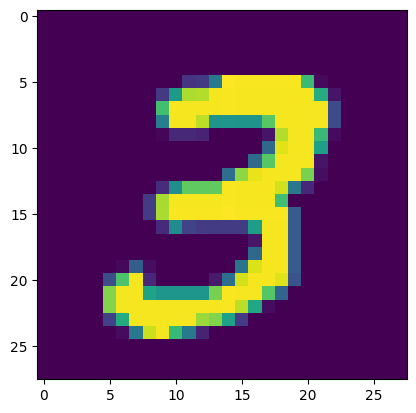

In [5]:
plt.imshow(train_images[7])

In [6]:
# Scaling the pixels to 0-1

train_images = train_images/255.0
test_images = test_images/255.0

In [7]:
# For CNN model we need a 3D Extra axis so we reshape the images
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)

# 3. Creating the function of the Model

In [8]:
def create_model(hyper_parameters):

  # create the model layers
  model = keras.Sequential([
        keras.layers.Conv2D(
           filters = hyper_parameters.Int('conv_1_filter',min_value=32,max_value=128,step=16),
           kernel_size=hyper_parameters.Choice('conv_1_kernel',values = [3,5]),
           activation='relu',
           input_shape=(28,28,1)
        ),
        keras.layers.Conv2D(
           filters = hyper_parameters.Int('conv_2_filter',min_value=32,max_value=64,step=16),
           kernel_size=hyper_parameters.Choice('conv_2_kernel',values = [3,5]),
           activation='relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hyper_parameters.Int('dense_1_units',min_value=32,max_value=128,step=16),
            activation='relu'
        ),
        keras.layers.Dense(10,activation='softmax')
    ])

  # compile the model
  model.compile(optimizer=keras.optimizers.Adam(hyper_parameters.Choice('learning_rate',values=[0.01,0.001])),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Using TensorFlow backend


<ipython-input-9-2bbfbe7dae29>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


# 4. Initialize the Hyperparameter tuner

In [10]:
tuner_search = RandomSearch(create_model,
                            objective = 'val_accuracy',
                            max_trials=5,
                            directory='output',
                            project_name='number_classifier')

# 5. Run the Tuner search

In [11]:
tuner_search.search(train_images,train_labels,epochs=5,validation_split=0.1)

Trial 5 Complete [00h 01m 23s]
val_accuracy: 0.9673333168029785

Best val_accuracy So Far: 0.9883333444595337
Total elapsed time: 00h 06m 30s


# 6. Get the best model

In [13]:
model = tuner_search.get_best_models()[0]

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        27680     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 1209002 (4.61 MB)
Trainable params: 1209002 (4.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 7. Fit the model

In [16]:
model.fit(train_images,train_labels,epochs=10,validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0606 - val_accuracy: 0.9845
Epoch 2/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0585 - val_accuracy: 0.9885
Epoch 3/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0702 - val_accuracy: 0.9870
Epoch 4/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0653 - val_accuracy: 0.9897
Epoch 5/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 0.0742 - val_accuracy: 0.9892
Epoch 6/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0882 - val_accuracy: 0.9882
Epoch 7/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0787 - val_accuracy

In [17]:
model.evaluate(test_images,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0867 - accuracy: 0.9851


[0.08667422086000443, 0.9850999712944031]

# ====> 98.51% Accuracy...

In [18]:
model.save('Number_Predictor.keras')